In [1]:
import numpy as np
import timeit
import pcs as pcs
import matplotlib.pyplot as plt
from nepc import nepc
from nepc.methods.mp import mp as mp
from nepc.methods.thomson import thomson as thomson
from nepc.util.constants import N2_DIATOMIC_CONSTANTS
from nepc.util.constants import MU_NITROGEN_KG
from nepc.util.constants import WAVENUMBER_PER_EV as WAVENUMBER_PER_EV
from numpy import exp

# Plot psi_v, v=10

In [2]:
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2(W3Deltau)', 'N2(Bp3Sigmau-)', 'N2(ap1Sigmau-)', 'N2(a1Pig)', 'N2(w1Deltau)', 'N2(C3Piu)', 'N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)', 'N2+(C2Sigmau+)'])

In [3]:
r_array, psi_p_X, psi_pp_X, Vr_p_X, Vr_pp_X = thomson.psi_v(vp=10, vpp=10,
                  diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                  diatomic_constants_pp=N2_DIATOMIC_CONSTANTS['N2+(A2Piu)'],
                  reduced_mass=MU_NITROGEN_KG,
                  k=17,
                  delta_r=.5,
                  dbug=False)

In [4]:
def Vr_array(Vr_p, r_array):
    return ((mp.Te(Vr_p['To'], Vr_p['we'], Vr_p['wexe']) + 
             Vr_p['De']*(1.0 - exp(-Vr_p['a']*(r_array - Vr_p['re'])))**2 )/WAVENUMBER_PER_EV)

In [5]:
Vr_p_X_array = Vr_array(Vr_p_X, r_array)
Vr_pp_X_array = Vr_array(Vr_pp_X, r_array)

In [6]:
Tv_p_X_10 = mp.Tv(10, Vr_p_X['To'], Vr_p_X['we'], Vr_p_X['wexe'])/WAVENUMBER_PER_EV
Tv_pp_X_10 = mp.Tv(10, Vr_pp_X['To'], Vr_pp_X['we'], Vr_pp_X['wexe'])/WAVENUMBER_PER_EV

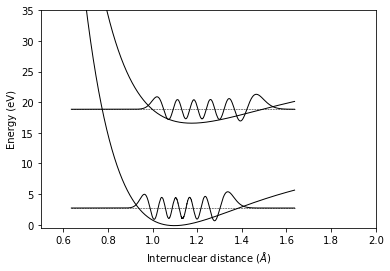

In [7]:
fig,  ax1 = plt.subplots(1)
ax1.plot(r_array, Vr_p_X_array, 'black',
         r_array, Vr_pp_X_array, 'black',
         r_array, psi_p_X + Tv_p_X_10, 'black', 
         r_array, psi_pp_X + Tv_pp_X_10, 'black', lw=1)
ax1.plot([r_array[0], r_array[-1]], [Tv_p_X_10,Tv_p_X_10], 'black', 
         [r_array[0], r_array[-1]], [Tv_pp_X_10,Tv_pp_X_10], 'black', ls='--', lw=.5)
ax1.set_xlim(.5, 2.0)
ax1.set_ylim(-0.5, 35)
ax1.set_ylabel('Energy (eV)')
ax1.set_xlabel('Internuclear distance ($\AA$)')
plt.show()

### For Delta r, 
### N2 X1Sigmag+ to N2+ X2Sigmag+, Delta r >= 0.45
### N2 X1Sigmag+ to N2+ A2Piu+, Delta r >= 0.50
### N2 X1Sigmag+ to N2+ B2Sigmau+, Delta r >= 0.45

# Compute Overlap Matrix and Check for Identity

In [8]:
from datetime import datetime

In [9]:
start = datetime.now()
overlap_X = thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)
stop = datetime.now()
print(stop - start)

0:00:15.174052


In [10]:
thomson.rmse_diagonal_elements(np.asarray(overlap_X))

4.115206214252541e-07

In [11]:
thomson.incremental_rmse_diagonal_elements(np.asarray(overlap_X))

i: 1; rmse: 1.2434497875801753e-14
i: 2; rmse: 5.844456963317449e-14
i: 3; rmse: 8.705960933385516e-14
i: 4; rmse: 1.3228087202133447e-13
i: 5; rmse: 8.628411822787013e-12
i: 6; rmse: 2.0702115185528743e-11
i: 7; rmse: 7.328597843980401e-10
i: 8; rmse: 2.784505527958912e-09
i: 9; rmse: 4.102019172911683e-08
i: 10; rmse: 2.1819391570116893e-07
i: 11; rmse: 4.115206214252541e-07


In [12]:
thomson.rmse_off_diagonal_elements(np.asarray(overlap_X))

6.141937313299019e-09

In [13]:
thomson.incremental_rmse_off_diagonal_elements(np.asarray(overlap_X))

i: 2; rmse: 2.074522339725268e-25
i: 3; rmse: 7.19577869861297e-24
i: 4; rmse: 1.4098660106951825e-21
i: 5; rmse: 5.293939028789621e-20
i: 6; rmse: 1.3997629509065152e-17
i: 7; rmse: 1.251273893768826e-15
i: 8; rmse: 3.987297853306026e-15
i: 9; rmse: 2.0832045321553765e-13
i: 10; rmse: 5.172114071122606e-11
i: 11; rmse: 6.141937313299019e-09


# Closure relationship for FCF
If the FCF sum over vpp for a given vp are greater than 0.99, that's were we'll stop including cross sections

TODO: we need to determine v'' for closure for all combinations of p' and p'' for v'=0-10.

In [34]:
def fcf_closure(fcf):
    vp_max = len(fcf)-1
    closure = []
    for vp in np.arange(vp_max):
        fcf_sum = 0
        vpp = 0
        for vpp in np.arange(11):
            if fcf_sum < 0.99:
                fcf_sum += fcf[vp][vpp]
            else:
                break
        if fcf_sum > 0.99:
            closure.append('vp: {}; vpp: {}; sum_fcf = {} > 0.99'.format(vp, vpp-1, fcf_sum))
        elif fcf_sum < 0.99:
            closure.append('vp: {}; vpp: {}; sum_fcf = {} < 0.99; FAILS'.format(vp, vpp-1, fcf_sum))
    return closure

# Computing closure for p' to p'' states

In [41]:
p_list = ['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2(W3Deltau)', 'N2(Bp3Sigmau-)', 'N2(ap1Sigmau-)', 'N2(a1Pig)', 'N2(w1Deltau)', 'N2(C3Piu)']
pp_list = ['N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)', 'N2+(C2Sigmau+)']

## X1Sigmag+

In [65]:
fcf_X1 = []
for pp in pp_list:
    fcf_X1.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False))

In [66]:
fcf_closure(fcf_X1[0])

['vp: 0; vpp: 1; sum_fcf = 0.997058799911257 > 0.99',
 'vp: 1; vpp: 3; sum_fcf = 0.9998834884690369 > 0.99',
 'vp: 2; vpp: 4; sum_fcf = 0.9995408773280239 > 0.99',
 'vp: 3; vpp: 5; sum_fcf = 0.9986500107497955 > 0.99',
 'vp: 4; vpp: 6; sum_fcf = 0.9967376292130717 > 0.99',
 'vp: 5; vpp: 7; sum_fcf = 0.9931604602006356 > 0.99',
 'vp: 6; vpp: 9; sum_fcf = 0.9992802887358266 > 0.99',
 'vp: 7; vpp: 9; sum_fcf = 0.9987654220079796 > 0.99',
 'vp: 8; vpp: 9; sum_fcf = 0.9643045736880783 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.7323236121903888 < 0.99; FAILS']

In [67]:
fcf_closure(fcf_X1[1])

['vp: 0; vpp: 5; sum_fcf = 0.9938864563071661 > 0.99',
 'vp: 1; vpp: 7; sum_fcf = 0.9907279254231203 > 0.99',
 'vp: 2; vpp: 9; sum_fcf = 0.9900026078737536 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9716748847740315 < 0.99; FAILS',
 'vp: 4; vpp: 9; sum_fcf = 0.86542311893636 < 0.99; FAILS',
 'vp: 5; vpp: 9; sum_fcf = 0.685323767356875 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.6136357458355904 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.611607884222799 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.5328664391653462 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.5402741504811926 < 0.99; FAILS']

In [68]:
fcf_closure(fcf_X1[2])

['vp: 0; vpp: 1; sum_fcf = 0.9961254039105287 > 0.99',
 'vp: 1; vpp: 2; sum_fcf = 0.9917624422914812 > 0.99',
 'vp: 2; vpp: 4; sum_fcf = 0.9997594280161222 > 0.99',
 'vp: 3; vpp: 5; sum_fcf = 0.9992726752163584 > 0.99',
 'vp: 4; vpp: 6; sum_fcf = 0.9983351655411763 > 0.99',
 'vp: 5; vpp: 6; sum_fcf = 0.990234846455668 > 0.99',
 'vp: 6; vpp: 7; sum_fcf = 0.9922290814958401 > 0.99',
 'vp: 7; vpp: 8; sum_fcf = 0.9926802762928186 > 0.99',
 'vp: 8; vpp: 9; sum_fcf = 0.9910648645307024 > 0.99',
 'vp: 9; vpp: 9; sum_fcf = 0.982039876366751 < 0.99; FAILS']

## A3Sigmau+

In [61]:
fcf_A3 = []
for pp in pp_list:
    fcf_A3.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(A3Sigmau+)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False))

In [63]:
fcf_closure(fcf_A3[1])

['vp: 0; vpp: 5; sum_fcf = 0.9982450765951602 > 0.99',
 'vp: 1; vpp: 6; sum_fcf = 0.9905894209800232 > 0.99',
 'vp: 2; vpp: 8; sum_fcf = 0.9971822034169983 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9920823749049258 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9818146149954714 < 0.99; FAILS',
 'vp: 5; vpp: 9; sum_fcf = 0.8132112486258044 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.49516476136413745 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.47023683367421565 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.34780361344208643 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.3232132449784663 < 0.99; FAILS']

In [94]:
fcf_closure(fcf_A3[3])

['vp: 0; vpp: 3; sum_fcf = 0.9961313360435532 > 0.99',
 'vp: 1; vpp: 5; sum_fcf = 0.9963874999428222 > 0.99',
 'vp: 2; vpp: 7; sum_fcf = 0.9947614662196247 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9967470917901096 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9898036777575396 < 0.99; FAILS',
 'vp: 5; vpp: 9; sum_fcf = 0.9153509516477826 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.7587562285364143 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.5723998964752812 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.5585406091423898 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.4995196108888875 < 0.99; FAILS']

## B3Pig

In [77]:
fcf_B3 = []
for pp in pp_list:
    fcf_B3.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(B3Pig)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False))

In [78]:
fcf_closure(fcf_B3[0])

['vp: 0; vpp: 5; sum_fcf = 0.9989916730943961 > 0.99',
 'vp: 1; vpp: 6; sum_fcf = 0.9945385979627724 > 0.99',
 'vp: 2; vpp: 8; sum_fcf = 0.9985903709593055 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.996064966636672 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9909191652560336 > 0.99',
 'vp: 5; vpp: 9; sum_fcf = 0.8802193019968756 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.5618123852234389 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.4813093118220114 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.37779566323231495 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.3613075943339519 < 0.99; FAILS']

In [95]:
fcf_closure(fcf_B3[3])

['vp: 0; vpp: 7; sum_fcf = 0.9941348948558748 > 0.99',
 'vp: 1; vpp: 9; sum_fcf = 0.9905959944824517 > 0.99',
 'vp: 2; vpp: 9; sum_fcf = 0.9610152359314074 < 0.99; FAILS',
 'vp: 3; vpp: 9; sum_fcf = 0.9003746114951535 < 0.99; FAILS',
 'vp: 4; vpp: 9; sum_fcf = 0.825240846779364 < 0.99; FAILS',
 'vp: 5; vpp: 9; sum_fcf = 0.7753395651155556 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.7736914944994989 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.7915913741104966 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.7628485293598724 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.7453906254592171 < 0.99; FAILS']

## W3Deltau

In [79]:
fcf_W3 = []
for pp in pp_list:
    fcf_W3.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(W3Deltau)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)) 

In [80]:
fcf_closure(fcf_W3[1])

['vp: 0; vpp: 4; sum_fcf = 0.9902133629625113 > 0.99',
 'vp: 1; vpp: 6; sum_fcf = 0.9949942076674905 > 0.99',
 'vp: 2; vpp: 8; sum_fcf = 0.9988273679394052 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9968756139074334 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9931206899792332 > 0.99',
 'vp: 5; vpp: 9; sum_fcf = 0.8996883113962235 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.5929019896359622 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.4820854342264164 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.398599144294156 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.37160702741765916 < 0.99; FAILS']

In [96]:
fcf_closure(fcf_W3[3])

['vp: 0; vpp: 2; sum_fcf = 0.9931496582751279 > 0.99',
 'vp: 1; vpp: 5; sum_fcf = 0.9981812335524438 > 0.99',
 'vp: 2; vpp: 6; sum_fcf = 0.9926282159664764 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.998427915668 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9952780974368995 > 0.99',
 'vp: 5; vpp: 9; sum_fcf = 0.9401881964687171 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.8416156678370089 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.5773332381545249 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.5468469925466936 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.5198590291378434 < 0.99; FAILS']

## B'3Sigmau-

In [81]:
fcf_Bp3 = []
for pp in pp_list:
    fcf_Bp3.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(Bp3Sigmau-)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)) 

In [82]:
fcf_closure(fcf_Bp3[1])

['vp: 0; vpp: 4; sum_fcf = 0.9910354574639592 > 0.99',
 'vp: 1; vpp: 6; sum_fcf = 0.9955484923189196 > 0.99',
 'vp: 2; vpp: 8; sum_fcf = 0.9990168416249309 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9974412757220753 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9944864504980647 > 0.99',
 'vp: 5; vpp: 9; sum_fcf = 0.9136594599094228 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.6195004392684085 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.48261084598963944 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.4164503959622943 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.37620985121077627 < 0.99; FAILS']

In [97]:
fcf_closure(fcf_Bp3[3])

['vp: 0; vpp: 2; sum_fcf = 0.9938363300019735 > 0.99',
 'vp: 1; vpp: 5; sum_fcf = 0.9983440907298371 > 0.99',
 'vp: 2; vpp: 6; sum_fcf = 0.9933641610329518 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9984281171866682 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9955621661223923 > 0.99',
 'vp: 5; vpp: 9; sum_fcf = 0.942379225524622 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.8554867672680518 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.5783304849948522 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.5403312925340905 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.5160873518653712 < 0.99; FAILS']

## a'1Sigmau-

In [83]:
fcf_ap1 = []
for pp in pp_list:
    fcf_ap1.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(ap1Sigmau-)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)) 

In [88]:
fcf_closure(fcf_ap1[1])

['vp: 0; vpp: 4; sum_fcf = 0.9910257717095987 > 0.99',
 'vp: 1; vpp: 6; sum_fcf = 0.9948728738122737 > 0.99',
 'vp: 2; vpp: 8; sum_fcf = 0.9985529865882862 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9963846481773835 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9925252076161638 > 0.99',
 'vp: 5; vpp: 9; sum_fcf = 0.9102727872124576 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.6414011395965846 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.5051953966930143 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.45687433651902554 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.39699048733612835 < 0.99; FAILS']

In [98]:
fcf_closure(fcf_ap1[3])

['vp: 0; vpp: 2; sum_fcf = 0.9938786571695724 > 0.99',
 'vp: 1; vpp: 5; sum_fcf = 0.9977275642574791 > 0.99',
 'vp: 2; vpp: 6; sum_fcf = 0.9914821098448463 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9966515641652415 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9918488213446041 > 0.99',
 'vp: 5; vpp: 9; sum_fcf = 0.9207143031595868 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.83659752315894 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.5380367209135818 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.5005894757777712 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.4759867213006288 < 0.99; FAILS']

## a1Pig

In [85]:
fcf_a1 = []
for pp in pp_list:
    fcf_a1.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(a1Pig)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)) 

In [89]:
fcf_closure(fcf_a1[0])

['vp: 0; vpp: 5; sum_fcf = 0.9945847859112319 > 0.99',
 'vp: 1; vpp: 7; sum_fcf = 0.9960099896295331 > 0.99',
 'vp: 2; vpp: 9; sum_fcf = 0.9984008326169683 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9956350206735447 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9423998623916847 < 0.99; FAILS',
 'vp: 5; vpp: 9; sum_fcf = 0.7224472553366127 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.5216388998639153 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.5097248865950738 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.40424495507482927 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.38172384747792115 < 0.99; FAILS']

In [99]:
fcf_closure(fcf_a1[3])

['vp: 0; vpp: 6; sum_fcf = 0.9911904234780348 > 0.99',
 'vp: 1; vpp: 9; sum_fcf = 0.9908397849359006 > 0.99',
 'vp: 2; vpp: 9; sum_fcf = 0.9620718629177024 < 0.99; FAILS',
 'vp: 3; vpp: 9; sum_fcf = 0.9028873432212046 < 0.99; FAILS',
 'vp: 4; vpp: 9; sum_fcf = 0.8292336900912148 < 0.99; FAILS',
 'vp: 5; vpp: 9; sum_fcf = 0.7774105772395271 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.7759601611064806 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.787696099294161 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.7122034223901539 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.6434007981341511 < 0.99; FAILS']

## w1Deltau

In [90]:
fcf_w1 = []
for pp in pp_list:
    fcf_w1.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(w1Deltau)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)) 

In [91]:
fcf_closure(fcf_w1[1])

['vp: 0; vpp: 4; sum_fcf = 0.9969633399752227 > 0.99',
 'vp: 1; vpp: 6; sum_fcf = 0.9990206443865781 > 0.99',
 'vp: 2; vpp: 7; sum_fcf = 0.9969669371984495 > 0.99',
 'vp: 3; vpp: 8; sum_fcf = 0.9929413124537944 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.999408493004598 > 0.99',
 'vp: 5; vpp: 9; sum_fcf = 0.9764799782301534 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.7850808203836712 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.4861690693725154 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.47062752576821476 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.35554192781269534 < 0.99; FAILS']

In [100]:
fcf_closure(fcf_w1[3])

['vp: 0; vpp: 2; sum_fcf = 0.9971636744467197 > 0.99',
 'vp: 1; vpp: 5; sum_fcf = 0.9984789069994857 > 0.99',
 'vp: 2; vpp: 6; sum_fcf = 0.9952394914416748 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9970438344433785 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9939292987209118 > 0.99',
 'vp: 5; vpp: 9; sum_fcf = 0.9546205507914467 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.913883112300261 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.6246560968288667 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.5367019540684163 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.4760628922927552 < 0.99; FAILS']

## C3Piu

In [92]:
fcf_C3 = []
for pp in pp_list:
    fcf_C3.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(C3Piu)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)) 

In [93]:
fcf_closure(fcf_C3[2])

['vp: 0; vpp: 5; sum_fcf = 0.9966595662066768 > 0.99',
 'vp: 1; vpp: 7; sum_fcf = 0.9965660883064286 > 0.99',
 'vp: 2; vpp: 9; sum_fcf = 0.9979424178351968 > 0.99',
 'vp: 3; vpp: 9; sum_fcf = 0.9945208371348635 > 0.99',
 'vp: 4; vpp: 9; sum_fcf = 0.9498901469837917 < 0.99; FAILS',
 'vp: 5; vpp: 9; sum_fcf = 0.7820094553686594 < 0.99; FAILS',
 'vp: 6; vpp: 9; sum_fcf = 0.5928033469782766 < 0.99; FAILS',
 'vp: 7; vpp: 9; sum_fcf = 0.5767230067707515 < 0.99; FAILS',
 'vp: 8; vpp: 9; sum_fcf = 0.4836183412373247 < 0.99; FAILS',
 'vp: 9; vpp: 9; sum_fcf = 0.46582008622438964 < 0.99; FAILS']